In [6]:
import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tensorboardX import SummaryWriter
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from tqdm import tqdm, trange
from torch.autograd import Variable

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LOADER_KWARGS = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}
print("Cuda available?: ",torch.cuda.is_available())

PI = 0.5
SIGMA_1 = torch.FloatTensor([math.exp(-0)])
SIGMA_2 = torch.FloatTensor([math.exp(-6)])


class Gaussian(object):
    def __init__(self, mu, rho):
        super().__init__()
        self.mu = mu
        self.rho = rho
        self.normal = torch.distributions.Normal(0,1)
    
    @property
    def sigma(self):
        return torch.log1p(torch.exp(self.rho))
    
    def sample(self):
        epsilon = self.normal.sample(self.rho.size()).to(DEVICE)
        return self.mu + self.sigma * epsilon
    
    def log_prob(self, input):
        return (-math.log(math.sqrt(2 * math.pi))
                - torch.log(self.sigma)
                - ((input - self.mu) ** 2) / (2 * self.sigma ** 2)).sum()

class ScaleMixtureGaussian(object):
    def __init__(self, pi, sigma1, sigma2):
        super().__init__()
        self.pi = pi
        self.sigma1 = sigma1
        self.sigma2 = sigma2
        self.gaussian1 = torch.distributions.Normal(0,sigma1)
        self.gaussian2 = torch.distributions.Normal(0,sigma2)
    
    def log_prob(self, input):
        prob1 = torch.exp(self.gaussian1.log_prob(input))
        prob2 = torch.exp(self.gaussian2.log_prob(input))
        return (torch.log(self.pi * prob1 + (1-self.pi) * prob2)).sum()

class BayesianLinear(nn.Module):
    def __init__(self, in_features, out_features, hasScalarMixturePrior):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        # Weight parameters
        self.weight_mu = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-0.2, 0.2))
        self.weight_rho = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-5,-4))
        self.weight = Gaussian(self.weight_mu, self.weight_rho)
        # Bias parameters
        self.bias_mu = nn.Parameter(torch.Tensor(out_features).uniform_(-0.2, 0.2))
        self.bias_rho = nn.Parameter(torch.Tensor(out_features).uniform_(-5,-4))
        self.bias = Gaussian(self.bias_mu, self.bias_rho)
        # Prior distributions
        self.weight_prior = 0
        self.bias_prior = 0
        if hasScalarMixturePrior == True:
            self.weight_prior = ScaleMixtureGaussian(PI, SIGMA_1, SIGMA_2)
            self.bias_prior = ScaleMixtureGaussian(PI, SIGMA_1, SIGMA_2)
        else:
            self.weight_prior_mu = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-0.2, 0.2))
            self.weight_prior_rho = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-5,-4))
            self.weight_prior = Gaussian(self.weight_prior_mu, self.weight_prior_rho)
            self.bias_prior_mu = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-0.2, 0.2))
            self.bias_prior_rho = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-5,-4))
            self.bias_prior = Gaussian(self.bias_prior_mu, self.bias_prior_rho)
        self.log_prior = 0
        self.log_variational_posterior = 0

    def forward(self, input, sample=False, calculate_log_probs=False):
        if self.training or sample:
            weight = self.weight.sample()
            bias = self.bias.sample()
        else:
            weight = self.weight.mu
            bias = self.bias.mu
        if self.training or calculate_log_probs:
            self.log_prior = self.weight_prior.log_prob(weight) + self.bias_prior.log_prob(bias)
            self.log_variational_posterior = self.weight.log_prob(weight) + self.bias.log_prob(bias)
        else:
            self.log_prior, self.log_variational_posterior = 0, 0

        return F.linear(input, weight, bias)

class BayesianNetwork(nn.Module):
    def __init__(self, inputSize, CLASSES, layers, activations, SAMPLES, BATCH_SIZE, NUM_BATCHES,hasScalarMixturePrior,pi,sigma1,sigma2):
        super().__init__()
        self.inputSize = inputSize
        self.activations = activations
        self.CLASSES = CLASSES
        self.SAMPLES = SAMPLES
        self.BATCH_SIZE = BATCH_SIZE
        self.NUM_BATCHES = NUM_BATCHES
        self.DEPTH = 0
        PI = pi
        SIGMA_1 = sigma1
        SIGMA_2 = sigma2

        self.layers = nn.ModuleList([])
        if layers.size == 0:
            self.layers.append(BayesianLinear(inputSize, CLASSES,hasScalarMixturePrior))
            self.DEPTH += 1
        else:
            self.layers.append(BayesianLinear(inputSize, layers[0],hasScalarMixturePrior))
            self.DEPTH += 1
            for i in range(layers.size-1):
                self.layers.append(BayesianLinear(layers[i], layers[i+1],hasScalarMixturePrior))
                self.DEPTH += 1
            self.layers.append(BayesianLinear(layers[layers.size-1], CLASSES,hasScalarMixturePrior))
            self.DEPTH += 1
            
    def forward(self, x, sample=False):
        x = x.view(-1, self.inputSize)
        layerNumber = 0
        for i in range(self.activations.size):
            if self.activations[i]=='relu':
                x = F.relu(self.layers[layerNumber](x, sample))
            elif self.activations[i]=='softmax':
                x = F.log_softmax(self.layers[layerNumber](x, sample), dim=1)
            else:
                x = self.layers[layerNumber](x, sample)
            layerNumber+= 1
        return x
    
    def log_prior(self):
        value = 0
        for i in range(self.DEPTH):
            value+= self.layers[i].log_prior
        return value
    
    def log_variational_posterior(self):
        value = 0
        for i in range(self.DEPTH):
            value+= self.layers[i].log_variational_posterior
        return value
    
    def sample_elbo(self, input, target):
        samples=self.SAMPLES
        outputs = torch.zeros(samples, self.BATCH_SIZE, self.CLASSES).to(DEVICE)
        log_priors = torch.zeros(samples).to(DEVICE)
        log_variational_posteriors = torch.zeros(samples).to(DEVICE)
        negative_log_likelihood = torch.zeros(samples).to(DEVICE)
        
        for i in range(samples):
            outputs[i] = self.forward(input, sample=True)
            log_priors[i] = self.log_prior()
            log_variational_posteriors[i] = self.log_variational_posterior()
            if self.CLASSES == 1:
                negative_log_likelihood[i] = (.5 * (target - outputs[i]) ** 2).sum()
            
        log_prior = log_priors.mean()
        log_variational_posterior = log_variational_posteriors.mean()
        if self.CLASSES > 1:
            negative_log_likelihood = F.nll_loss(outputs.mean(0), target, size_average=False)
        else:
            negative_log_likelihood = negative_log_likelihood.mean()
        loss = (log_variational_posterior - log_prior)/self.NUM_BATCHES + negative_log_likelihood
        return loss, log_prior, log_variational_posterior, negative_log_likelihood

Cuda available?:  False


# Regression

Generating Data set.


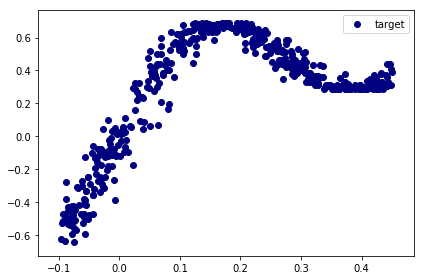

(5, 100)
Training Begins!
Training Ends!


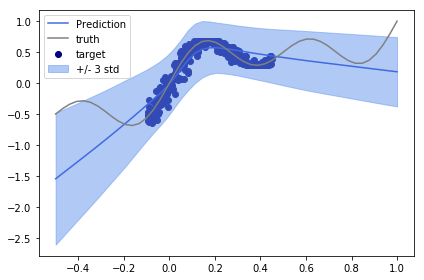

In [2]:
def train(net, optimizer, data, target, NUM_BATCHES):
    net.train()
    for i in range(NUM_BATCHES):
        net.zero_grad()
        x = data[i].reshape((-1, 1))
        y = target[i].reshape((-1,1))
        loss, log_prior, log_variational_posterior, negative_log_likelihood = net.sample_elbo(x,y)
        loss.backward()
        optimizer.step()

TRAIN_EPOCHS = 500
SAMPLES = 1
TEST_SAMPLES = 10
BATCH_SIZE = 100
NUM_BATCHES = 5
TEST_BATCH_SIZE = 50
CLASSES = 1

print('Generating Data set.')

Var = lambda x, dtype=torch.FloatTensor: Variable(torch.from_numpy(x).type(dtype))

x = np.random.uniform(-0.1, 0.45, size=(NUM_BATCHES,BATCH_SIZE))
noise = np.random.normal(0, 0.02, size=(NUM_BATCHES,BATCH_SIZE))
y = x + 0.3*np.sin(2*np.pi*(x+noise)) + 0.3*np.sin(4*np.pi*(x+noise)) + noise
X = Var(x)
Y = Var(y)

x_test = np.linspace(-0.5, 1,TEST_BATCH_SIZE)
y_test = x_test + 0.3*np.sin(2*np.pi*x_test) + 0.3*np.sin(4*np.pi*x_test)
X_test = Var(x_test)

plt.scatter(x, y, c='navy', label='target')
plt.legend()
plt.tight_layout()
plt.show()
print(x.shape)

#Training
print('Training Begins!')
net = BayesianNetwork(inputSize = 1,\
                      CLASSES = CLASSES, \
                      layers=np.array([100,400,400]), \
                      activations = np.array(['relu','relu','relu','none']), \
                      SAMPLES = SAMPLES, \
                      BATCH_SIZE = BATCH_SIZE,\
                      NUM_BATCHES = NUM_BATCHES,\
                      hasScalarMixturePrior = True).to(DEVICE)
optimizer = optim.Adam(net.parameters())
for epoch in range(TRAIN_EPOCHS):
    train(net, optimizer,data=X,target=Y,NUM_BATCHES=NUM_BATCHES)

print('Training Ends!')

#Testing
outputs = torch.zeros(TEST_SAMPLES+1, TEST_BATCH_SIZE, CLASSES).to(DEVICE)
for i in range(TEST_SAMPLES):
    outputs[i] = net.forward(X_test)
outputs[TEST_SAMPLES] = net.forward(X_test)
pred_mean = outputs.mean(0).data.numpy().squeeze(1)
pred_std = outputs.std(0).data.numpy().squeeze(1)

plt.scatter(x, y, c='navy', label='target')

plt.plot(x_test, pred_mean, c='royalblue', label='Prediction')
plt.fill_between(x_test, pred_mean - 3 * pred_std, pred_mean + 3 * pred_std,
                     color='cornflowerblue', alpha=.5, label='+/- 3 std')

plt.plot(x_test, y_test, c='grey', label='truth')

plt.legend()
plt.tight_layout()
plt.show()

# Classification

In [5]:
#Downloading training Data
print("Downloading MNIST Data")

BATCH_SIZE = 100
TEST_BATCH_SIZE = 5
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        './mnist', train=True, download=True,
        transform=transforms.ToTensor()),
    batch_size=BATCH_SIZE, shuffle=True, **LOADER_KWARGS)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        './mnist', train=False, download=True,
        transform=transforms.ToTensor()),
    batch_size=TEST_BATCH_SIZE, shuffle=False, **LOADER_KWARGS)

TRAIN_SIZE = len(train_loader.dataset)
TEST_SIZE = len(test_loader.dataset)
NUM_BATCHES = len(train_loader)
NUM_TEST_BATCHES = len(test_loader)

CLASSES = 10
TRAIN_EPOCHS = 20
SAMPLES = 2
TEST_SAMPLES = 10

assert (TRAIN_SIZE % BATCH_SIZE) == 0
assert (TEST_SIZE % TEST_BATCH_SIZE) == 0

In [ ]:
def train(net, optimizer):
    net.train()
    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
        data, target = data.to(DEVICE), target.to(DEVICE)
        net.zero_grad()
        loss, log_prior, log_variational_posterior, negative_log_likelihood = net.sample_elbo(data, target)
        loss.backward()
        optimizer.step()

#Declare the Bayesian Network
net = BayesianNetwork(inputSize = 28*28,\
                      CLASSES = 10, \
                      layers=np.array([400,400]), \
                      activations = np.array(['relu','relu','softmax']), \
                      SAMPLES = SAMPLES, \
                      BATCH_SIZE = BATCH_SIZE,\
                      NUM_BATCHES = NUM_BATCHES,\
                      hasScalarMixturePrior = True).to(DEVICE)

optimizer = optim.Adam(net.parameters())
for epoch in range(TRAIN_EPOCHS):
    train(net, optimizer)
    
def test_ensemble():
    net.eval()
    correct = 0
    corrects = np.zeros(TEST_SAMPLES+1, dtype=int)
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            outputs = torch.zeros(TEST_SAMPLES+1, TEST_BATCH_SIZE, CLASSES).to(DEVICE)
            for i in range(TEST_SAMPLES):
                outputs[i] = net(data, sample=True)
            outputs[TEST_SAMPLES] = net(data, sample=False)
            output = outputs.mean(0)
            preds = preds = outputs.max(2, keepdim=True)[1]
            pred = output.max(1, keepdim=True)[1] # index of max log-probability
            corrects += preds.eq(target.view_as(pred)).sum(dim=1).squeeze().cpu().numpy()
            correct += pred.eq(target.view_as(pred)).sum().item()
    for index, num in enumerate(corrects):
        if index < TEST_SAMPLES:
            print('Component {} Accuracy: {}/{}'.format(index, num, TEST_SIZE))
        else:
            print('Posterior Mean Accuracy: {}/{}'.format(num, TEST_SIZE))
    print('Ensemble Accuracy: {}/{}'.format(correct, TEST_SIZE))

test_ensemble()

# FMNIST

In [26]:
BATCH_SIZE = 100
TEST_BATCH_SIZE = 5

train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST(
        './fmnist', train=True, download=True,
        transform=transforms.ToTensor()),
    batch_size=BATCH_SIZE, shuffle=True, **LOADER_KWARGS)
test_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST(
        './fmnist', train=False, download=True,
        transform=transforms.ToTensor()),
    batch_size=TEST_BATCH_SIZE, shuffle=False, **LOADER_KWARGS)

TRAIN_SIZE = len(train_loader.dataset)
TEST_SIZE = len(test_loader.dataset)
NUM_BATCHES = len(train_loader)
NUM_TEST_BATCHES = len(test_loader)

CLASSES = 10
TRAIN_EPOCHS = 20
SAMPLES = 2
TEST_SAMPLES = 10

assert (TRAIN_SIZE % BATCH_SIZE) == 0
assert (TEST_SIZE % TEST_BATCH_SIZE) == 0

Processing...
Done!


In [28]:
PI = 0.5
SIGMA_1 = torch.FloatTensor([math.exp(-0)])
SIGMA_2 = torch.FloatTensor([math.exp(-6)])

In [29]:
def train(net, optimizer):
    net.train()
    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
        data, target = data.to(DEVICE), target.to(DEVICE)
        net.zero_grad()
        loss, log_prior, log_variational_posterior, negative_log_likelihood = net.sample_elbo(data, target)
        loss.backward()
        optimizer.step()
        

In [ ]:
net = BayesianNetwork(inputSize = 28*28,\
                      CLASSES = 10, \
                      layers=np.array([400,400]), \
                      activations = np.array(['relu','relu','softmax']), \
                      SAMPLES = SAMPLES, \
                      BATCH_SIZE = BATCH_SIZE,\
                      NUM_BATCHES = NUM_BATCHES,\
                      hasScalarMixturePrior = True).to(DEVICE)

optimizer = optim.Adam(net.parameters())
for epoch in range(TRAIN_EPOCHS):
    train(net, optimizer)

In [32]:
def test_ensemble():
    net.eval()
    correct = 0
    corrects = np.zeros(TEST_SAMPLES+1, dtype=int)
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            outputs = torch.zeros(TEST_SAMPLES+1, TEST_BATCH_SIZE, CLASSES).to(DEVICE)
            for i in range(TEST_SAMPLES):
                outputs[i] = net(data, sample=True)
            outputs[TEST_SAMPLES] = net(data, sample=False)
            output = outputs.mean(0)
            preds = preds = outputs.max(2, keepdim=True)[1]
            pred = output.max(1, keepdim=True)[1] # index of max log-probability
            corrects += preds.eq(target.view_as(pred)).sum(dim=1).squeeze().cpu().numpy()
            correct += pred.eq(target.view_as(pred)).sum().item()
    for index, num in enumerate(corrects):
        if index < TEST_SAMPLES:
            print('Component {} Accuracy: {}/{}'.format(index, num, TEST_SIZE))
        else:
            print('Posterior Mean Accuracy: {}/{}'.format(num, TEST_SIZE))
    print('Ensemble Accuracy: {}/{}'.format(correct, TEST_SIZE))

test_ensemble()

Component 0 Accuracy: 8520/10000
Component 1 Accuracy: 8527/10000
Component 2 Accuracy: 8561/10000
Component 3 Accuracy: 8553/10000
Component 4 Accuracy: 8551/10000
Component 5 Accuracy: 8585/10000
Component 6 Accuracy: 8579/10000
Component 7 Accuracy: 8558/10000
Component 8 Accuracy: 8590/10000
Component 9 Accuracy: 8555/10000
Posterior Mean Accuracy: 8689/10000
Ensemble Accuracy: 8779/10000


In [33]:
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

tensor([9, 2, 1, 1, 6])


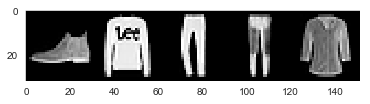

In [34]:
fmnist_sample = iter(test_loader).next()
fmnist_sample[0] = fmnist_sample[0].to(DEVICE)
print(fmnist_sample[1])
sns.set_style("dark")
show(make_grid(fmnist_sample[0].cpu()))

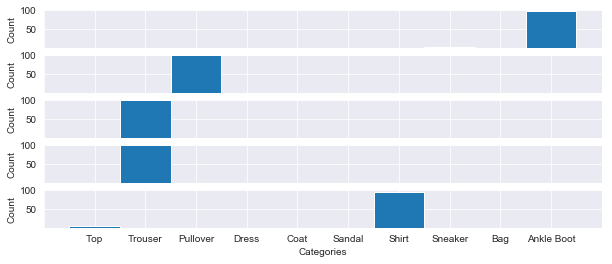

In [35]:
net.eval()
fmnist_outputs = net(fmnist_sample[0], True).max(1, keepdim=True)[1].detach().cpu().numpy()
for _ in range(99):
    fmnist_outputs = np.append(fmnist_outputs, net(fmnist_sample[0], True).max(1, keepdim=True)[1].detach().cpu().numpy(), axis=1)
sns.set_style("darkgrid")
plt.subplots(5,1,figsize=(10,4))
for i in range(5):
    plt.subplot(5,1,i+1)
    plt.ylim(0,100)
    plt.xlabel("Categories")
    plt.xticks(range(10), ["Top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"])
    plt.ylabel("Count")
    plt.yticks(range(50,101,50))
    plt.hist(fmnist_outputs[i], np.arange(-0.5, 10, 1))

In [36]:
mnist_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./mnist', train=False, download=True, transform=transforms.ToTensor()), batch_size=5, shuffle=False)

Processing...
Done!


tensor([7, 2, 1, 0, 4])


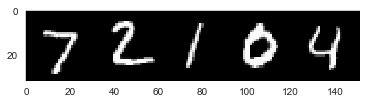

In [37]:
mnist_sample = iter(mnist_loader).next()
mnist_sample[0] = mnist_sample[0].to(DEVICE)
print(mnist_sample[1])
sns.set_style("dark")
show(make_grid(mnist_sample[0].cpu()))

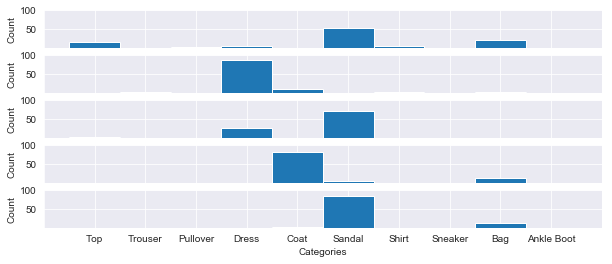

In [38]:
net.eval()
mnist_outputs = net(mnist_sample[0], True).max(1, keepdim=True)[1].detach().cpu().numpy()
for _ in range(99):
    mnist_outputs = np.append(mnist_outputs, net(mnist_sample[0], True).max(1, keepdim=True)[1].detach().cpu().numpy(), axis=1)

sns.set_style("darkgrid")
plt.subplots(5,1,figsize=(10,4))
for i in range(5):
    plt.subplot(5,1,i+1)
    plt.ylim(0,100)
    plt.xlabel("Categories")
    plt.xticks(range(10), ["Top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"])
    plt.ylabel("Count")
    plt.yticks(range(50,101,50))
    plt.hist(mnist_outputs[i], np.arange(-0.5, 10, 1))